In [1]:
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
import matplotlib.pyplot as plt
import torchvision
import numpy as np
from IPython.display import display, clear_output

from SRDiffusion import ScoreNet
from SDE import marginal_prob_std_fn, loss_fn, loss_fn_sr, diffusion_coeff_fn
from samplers import ode_sampler
from globals import device

### Train Generation Diffusion Model

In [3]:
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)
n_epochs = 800
## size of a mini-batch
batch_size = 32
## learning rate
lr = 1e-3
overfit = True
dataset = MNIST(".", train=True, transform=transforms.ToTensor(), download=True)

if overfit:
    dataset = torch.utils.data.Subset(dataset, [0])
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
optimizer = Adam(score_model.parameters(), lr=lr)

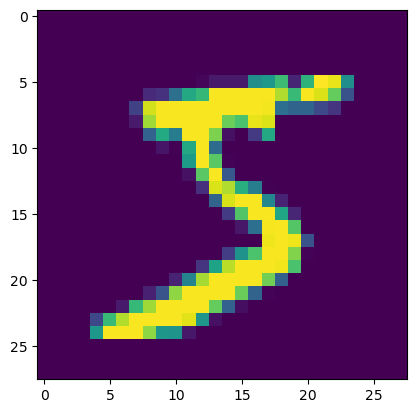

In [22]:
img_np = np.transpose(dataset[0][0].cpu().numpy(), (1,2,0))

plt.imshow(img_np, label="test")

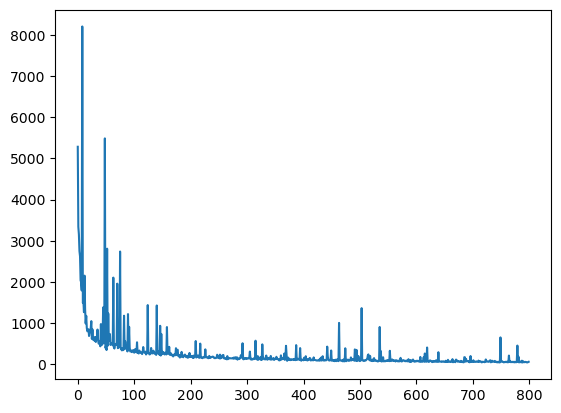

Average Loss: 61.961163: 100%|██████████| 800/800 [31:14<00:00,  2.34s/it]


In [24]:
# Create a figure and a line object
fig, ax = plt.subplots()
line, = ax.plot([], [])
display(fig)
x_data = []
y_data = []

tqdm_epoch = tqdm.trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.0
    num_items = 0
    for x, y in data_loader:
        x = x.to(device)
        loss, rand_t, z, std, perturbed_x, score = loss_fn(score_model, x, marginal_prob_std_fn, debug=overfit)
        # print(f"Rand_t is {rand_t}")
        # print(f"Latent noise is {z.shape} (compared to base shape {x.shape})")
        # print(f"std is {std}")
        x_np = np.transpose(x.cpu().numpy()[0, :, :, :], (1,2,0))
        perturbed_np = np.transpose(perturbed_x.cpu().numpy()[0, :, :, :], (1,2,0))
        # f, axarr = plt.subplots(1,2)
        # axarr[0].imshow(x_np)
        # axarr[1].imshow(perturbed_np)
        # plt.show()
        # print(f"Scroe is {score.shape}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    
    x_data.append(epoch)
    y_data.append(avg_loss / num_items)
    line.set_data(x_data, y_data)
    ax.relim() 
    ax.autoscale_view(True,True,True)
    clear_output(wait=True)
    display(fig)
    # print(f"received loss {loss}")
    # Print the averaged training loss so far.
    tqdm_epoch.set_description("Average Loss: {:5f}".format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), "ckpt.pth")

plt.close()

/Users/hannesleonhard/Documents/MasterInfo/SR-Diffusion/SDE.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device, dtype=torch.float32)


Number of function evaluations: 560


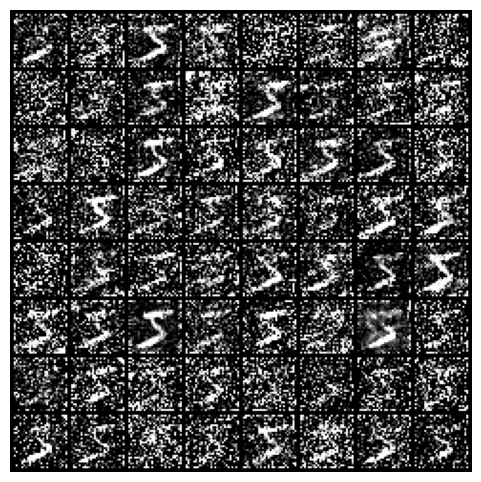

In [ ]:
from torchvision.utils import make_grid

ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64

samples = ode_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

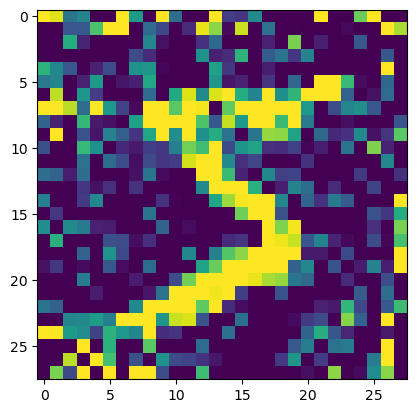

In [6]:
img_np = np.transpose(samples[2].cpu().numpy(), (1,2,0))

plt.imshow(img_np, label="test")

### Train SR Diffusion Model

In [ ]:
score_model = torch.nn.DataParallel(
    ScoreNet(marginal_prob_std=marginal_prob_std_fn, in_channels=2)
)
score_model = score_model.to(device)
n_epochs = 1200
## size of a mini-batch
batch_size = 32
## learning rate
lr = 1e-4
overfit = False
dataset = MNIST(".", train=True, transform=transforms.ToTensor(), download=True)
if overfit:
    dataset = torch.utils.data.Subset(dataset, [0, 1])
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
optimizer = Adam(score_model.parameters(), lr=lr)

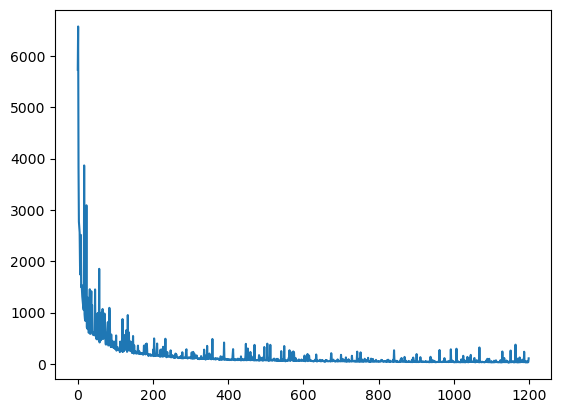

Average Loss: 106.903343: 100%|██████████| 1200/1200 [51:24<00:00,  2.57s/it]


In [3]:
# Create a figure and a line object
fig, ax = plt.subplots()
(line,) = ax.plot([], [])
display(fig)
x_data = []
y_data = []

tqdm_epoch = tqdm.trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.0
    num_items = 0
    for x, y in data_loader:
        x = x.to(device)
        loss, rand_t, z, std, perturbed_x, score = loss_fn_sr(
            score_model, x, marginal_prob_std_fn, debug=overfit
        )
        # print(f"Rand_t is {rand_t}")
        # print(f"Latent noise is {z.shape} (compared to base shape {x.shape})")
        # print(f"std is {std}")
        # x_np = np.transpose(x.cpu().numpy()[0, :, :, :], (1, 2, 0))
        # perturbed_np = np.transpose(perturbed_x.cpu().numpy()[0, :, :, :], (1, 2, 0))
        # f, axarr = plt.subplots(1,2)
        # axarr[0].imshow(x_np)
        # axarr[1].imshow(perturbed_np)
        # plt.show()
        # print(f"Scroe is {score.shape}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    x_data.append(epoch)
    y_data.append(avg_loss / num_items)
    line.set_data(x_data, y_data)
    ax.relim()
    ax.autoscale_view(True, True, True)
    clear_output(wait=True)
    display(fig)
    # print(f"received loss {loss}")
    # Print the averaged training loss so far.
    tqdm_epoch.set_description("Average Loss: {:5f}".format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), "ckpt.pth")

plt.close()

/Users/hannesleonhard/Documents/MasterInfo/SR-Diffusion/SDE.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device, dtype=torch.float32)


Number of function evaluations: 494


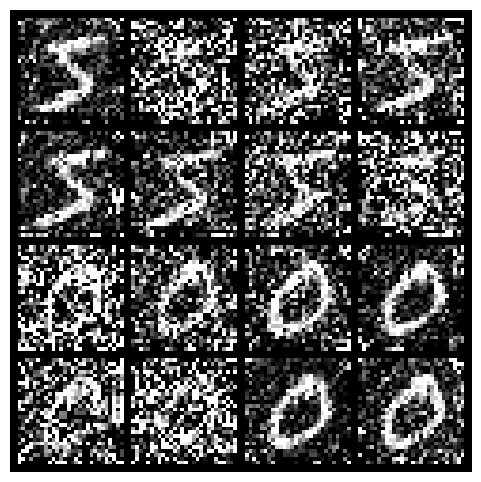

In [3]:
from torchvision.utils import make_grid

ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 16
a = torchvision.transforms.functional.adjust_sharpness(dataset[0][0], 0.01)
b = torchvision.transforms.functional.adjust_sharpness(dataset[1][0], 0.01)
conditioning_x = torch.zeros(16, 1, 28, 28)
conditioning_x[:8] = a  # broadcast to (16, 1, 28, 28)
conditioning_x[8:] = b
conditioning_x = conditioning_x.to(device=device)
samples = ode_sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size,
                  conditioning_x=conditioning_x)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()